# Análise Exploratória de Dados

**Autor:** Vinícius de Paula R Carvalho

**Data:** 07 de agosto de 2025

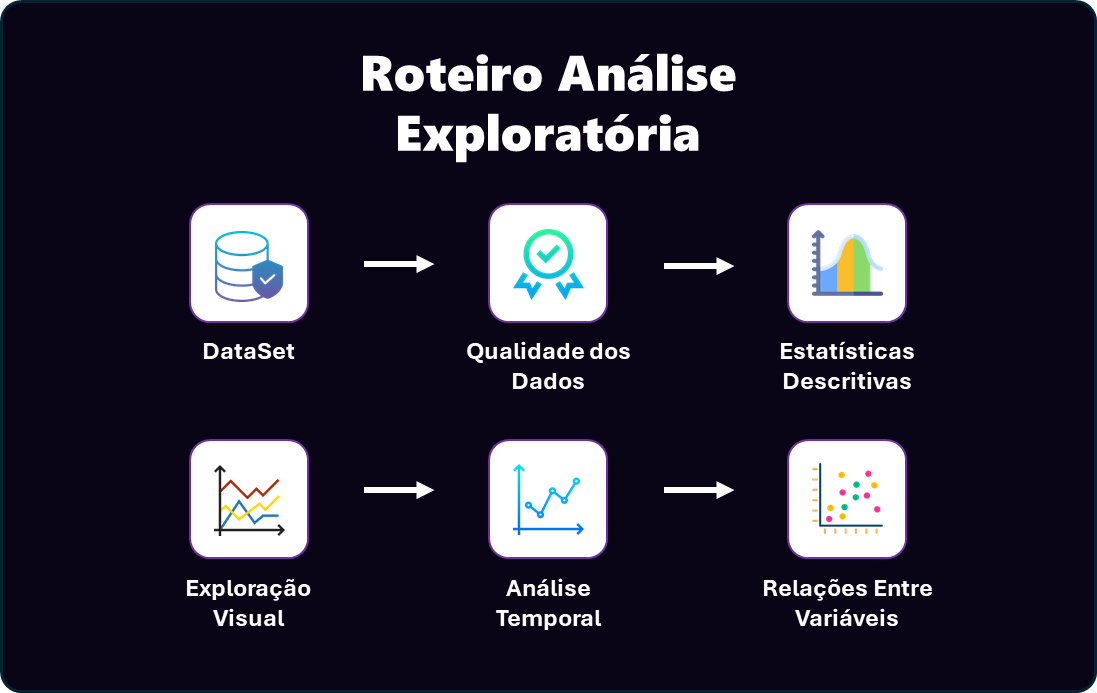

Após a conclusão bem-sucedida do pipeline de Extração, Transformação e Carga (ETL), nosso projeto entra em sua primeira fase analítica, a Análise Exploratória de Dados (AED). A importância desta etapa para este projeto em específico é fundamental, pois ela serve como a ponte entre a coleta de dados brutos e a geração de insights profundos através de modelos de NLP. Antes de aplicarmos algoritmos complexos para entender o sentimento ou os tópicos das postagens, é imperativo que primeiro compreendamos a natureza fundamental e a estrutura dos dados que coletamos. A Análise Exploratória nos permitirá visualizar as distribuições de métricas chave, como as taxas de engajamento, a frequência e a recência das publicações, permitindo-nos identificar padrões iniciais, outliers e possíveis correlações entre as estratégias de comunicação dos diferentes governadores. É nesta fase que validaremos a qualidade dos dados, investigaremos as características das métricas que criamos e formularemos as hipóteses iniciais que guiarão nossa modelagem subsequente, garantindo que nossas perguntas sejam relevantes e que nossos modelos sejam aplicados sobre uma base de dados sólida e bem compreendida. Como primeira linha de codigo, da mesma maneira no script anterior, o script atual será adicionado ao sys.path do projeto para que os dados e scripts possam ser encontrados por este notebook.

In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_extract.ETL import ELT
from config import settings
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.2f}'.format)

## Leitura e Qualidade dos dados

Esta seção representa a **etapa fundamental de preparação e higienização dos dados**, que é crucial para qualquer análise exploratória confiável. Ao pré-definir os tipos de dados de cada coluna através do dicionário `dtype` antes mesmo de carregar o arquivo, o processo garante a **integridade das informações** (tratando IDs como texto e números como inteiros de forma correta), **otimiza drasticamente o uso de memória** e **acelera o processamento**, especialmente com os tipos `int32` e `category`. A remoção imediata de colunas irrelevantes com o método `.drop()` **foca o dataset** nos atributos que realmente importam, criando uma **base de dados limpa, estruturada e eficiente**, sobre a qual a análise subsequente pode ser executada com **precisão e segurança**. Logo abaixo será possível analisar este processo para a primeira base de dados criada, com registros dos perfis dos governadores

In [2]:
dtype = {
    'inputUrl': 'str',
    'id': 'str',  # IDs são melhor tratados como texto
    'username': 'str',
    'url': 'str',
    'fullName': 'str',
    'biography': 'str',
    'externalUrls': 'str', # Provavelmente JSON, ler como texto primeiro
    'externalUrl': 'str',
    'externalUrlShimmed': 'str',
    'followersCount': 'int32',  # int32 economiza memória
    'followsCount': 'int32',
    'hasChannel': 'bool',
    'highlightReelCount': 'int32',
    'isBusinessAccount': 'bool',
    'joinedRecently': 'bool',
    'businessCategoryName': 'category',  # 'category' é ideal para textos repetidos
    'private': 'bool',
    'verified': 'bool',
    'profilePicUrl': 'str',
    'profilePicUrlHD': 'str',
    'igtvVideoCount': 'int32',
    'relatedProfiles': 'str', # Provavelmente JSON, ler como texto primeiro
    'latestIgtvVideos': 'str',
    'latestPosts': 'str',
    'postsCount': 'int32',
    'fbid': 'str',  # IDs são melhor tratados como texto
    'businessAddress': 'str'
}
df_profiles = pd.read_excel(settings.ALL_XLSX, sheet_name="profiles", dtype=dtype).drop(['highlightReelCount', 'igtvVideoCount', 'latestPosts', 'latestIgtvVideos', 'relatedProfiles'], axis=1)
df_profiles['inputUrl'] = df_profiles['inputUrl'].str[:-1]
df_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inputUrl              27 non-null     object        
 1   id                    27 non-null     object        
 2   username              27 non-null     object        
 3   url                   27 non-null     object        
 4   fullName              27 non-null     object        
 5   biography             27 non-null     object        
 6   externalUrls          27 non-null     object        
 7   externalUrl           21 non-null     object        
 8   externalUrlShimmed    21 non-null     object        
 9   followersCount        27 non-null     int32         
 10  followsCount          27 non-null     int32         
 11  hasChannel            27 non-null     bool          
 12  isBusinessAccount     27 non-null     bool          
 13  joinedRecently        

A execução do código `df_profiles.info()` nos fornece um sumário técnico essencial sobre a estrutura e a qualidade do nosso conjunto de dados após a etapa inicial de carregamento e limpeza. A saída confirma que o DataFrame `df_profiles` contém **27 entradas (linhas)**, correspondendo aos perfis dos 27 governadores, e **22 colunas (atributos)**. A aplicação do dicionário `dtype` foi bem-sucedida, como podemos ver pelos tipos de dados otimizados: as colunas numéricas como `followersCount` são do tipo `int32`, as categóricas como `businessCategoryName` são do tipo `category`, e as lógicas como `isBusinessAccount` são do tipo `bool`, resultando em um uso de memória eficiente de apenas **3.7+ KB**.

Além da validação da estrutura, o sumário revela pontos críticos para a análise exploratória. A contagem de valores não nulos (`Non-Null Count`) mostra que as colunas `externalUrl`, `externalUrlShimmed` e `businessCategoryName` possuem dados ausentes, necessitando de tratamento específico. Mais notavelmente, a coluna `businessAddress` tem apenas **1 entrada preenchida de 27**, o que a torna praticamente inútil para análise e uma forte candidata a ser removida. Este diagnóstico inicial é fundamental para guiar os próximos passos da limpeza e da análise de dados, garantindo que as conclusões sejam baseadas em um conjunto de dados íntegro e bem compreendido.

No codigo abaixo, o mesmo processo executado para os dados dos perfis dos governadores será executado na base de dados com os registros de publicações no reels dos mesmos.

In [3]:
dtype = {
    'inputUrl': 'object',
    'id': 'str',
    'type': 'object',
    'shortCode': 'object',
    'caption': 'object',
    'hashtags': 'object',
    'mentions': 'object',
    'url': 'object',
    'commentsCount': 'int64',
    'firstComment': 'object',
    'latestComments': 'object',
    'dimensionsHeight': 'str',
    'dimensionsWidth': 'str',
    'displayUrl': 'object',
    'images': 'object',
    'videoUrl': 'object',
    'alt': 'float64',
    'likesCount': 'int64',
    'videoViewCount': 'int64',
    'videoPlayCount': 'int64',
    'timestamp': 'object',
    'childPosts': 'object',
    'ownerFullName': 'object',
    'ownerUsername': 'object',
    'ownerId': 'str',
    'productType': 'object',
    'videoDuration': 'float64',
    'isSponsored': 'bool',
    'musicInfo': 'object',
    'isCommentsDisabled': 'bool',
    'taggedUsers': 'object',
    'coauthorProducers': 'object',
    'locationName': 'object',
    'locationId': 'str',
    'isPinned': 'float64',
    'data_hora': 'datetime64[ns]',
    'Tipo': 'object'
}
df_reels = pd.read_excel(settings.ALL_XLSX, sheet_name="reels", dtype=dtype).drop(['firstComment', 'latestComments', 'videoUrl', 'alt', 
                                                                                    'timestamp', 'childPosts', 'productType', 'taggedUsers', 
                                                                                    'type', 'hashtags', 'displayUrl', 'dimensionsHeight', 'dimensionsWidth',
                                                                                    'images', 'Tipo'], axis=1)
df_reels['isPinned'] = df_reels['isPinned'].astype(bool)  
df_reels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inputUrl              810 non-null    object        
 1   id                    810 non-null    object        
 2   shortCode             810 non-null    object        
 3   caption               810 non-null    object        
 4   mentions              810 non-null    object        
 5   url                   810 non-null    object        
 6   commentsCount         810 non-null    int64         
 7   likesCount            810 non-null    int64         
 8   videoViewCount        810 non-null    int64         
 9   videoPlayCount        810 non-null    int64         
 10  ownerFullName         810 non-null    object        
 11  ownerUsername         810 non-null    object        
 12  ownerId               810 non-null    object        
 13  videoDuration       

No codigo acima, a leitura dos dados é feita de forma robusta através do comando `pd.read_excel`, onde o uso do parâmetro `dtype` é um destaque. Ao especificar o tipo de dado esperado para cada coluna, o código evita ambiguidades na interpretação do pandas, garantindo a integridade dos dados e otimizando o uso de memória. Isso previne que identificadores numéricos sejam lidos como `float` ou que datas sejam interpretadas incorretamente.

Imediatamente após a carga, é realizada uma limpeza agressiva e estratégica com o método `.drop()`. Esta etapa é crucial para focar o dataset nos atributos que são verdadeiramente relevantes para a análise. As colunas removidas podem ser categorizadas como: redundantes (ex: `timestamp`, já representada por `data_hora`), de conteúdo aninhado e complexo que exigiria tratamento à parte (ex: `latestComments`, `childPosts`, `taggedUsers`), ou metadados irrelevantes para as perguntas de negócio deste projeto (ex: `alt`, `productType`, `dimensionsHeight`). Essa seleção criteriosa resulta em um DataFrame muito mais enxuto e manuseável.

A linha `df_reels['isPinned'] = df_reels['isPinned'].astype(bool)` realiza uma importante conversão de tipo. Ela transforma uma coluna que provavelmente foi lida como numérica (`float64`) em um tipo booleano (`True`/`False`), que é semanticamente mais correto e mais intuitivo para ser usado em filtros e operações lógicas. A chamada `df_reels.info()` ao final serve para inspecionar e validar o resultado de todas essas operações, confirmando que o DataFrame `df_reels` agora possui 23 colunas, com os tipos de dados devidamente ajustados e pronto para as próximas fases de análise exploratória e modelagem.

In [4]:
dtypes = {
    'inputUrl': 'object',
    'id': 'object',
    'type': 'object',
    'shortCode': 'object',
    'caption': 'object',
    'mentions': 'object',
    'url': 'object',
    'commentsCount': 'int64',
    'likesCount': 'int64',
    'videoViewCount': 'float64',
    'videoPlayCount': 'float64',
    'ownerFullName': 'object',
    'ownerUsername': 'object',
    'ownerId': 'object',
    'videoDuration': 'float64',
    'isSponsored': 'bool',
    'isPinned': 'float64',
    'isCommentsDisabled': 'bool',
    'coauthorProducers': 'object',
    'locationName': 'object',
}
df_posts = pd.read_excel(settings.ALL_XLSX, sheet_name="posts", dtype=dtypes).drop(['firstComment', 'latestComments', 'videoUrl', 'alt', 
                                                                        'timestamp', 'childPosts', 'productType', 'taggedUsers', 
                                                                        'hashtags', 'displayUrl', 'dimensionsHeight', 'dimensionsWidth',
                                                                        'images', 'Tipo','musicInfo','locationId'], axis=1)
df_posts['isPinned'] = df_posts['isPinned'].astype(bool)
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   inputUrl            810 non-null    object        
 1   id                  810 non-null    object        
 2   type                810 non-null    object        
 3   shortCode           810 non-null    object        
 4   caption             809 non-null    object        
 5   mentions            810 non-null    object        
 6   url                 810 non-null    object        
 7   commentsCount       810 non-null    int64         
 8   likesCount          810 non-null    int64         
 9   videoViewCount      564 non-null    float64       
 10  videoPlayCount      564 non-null    float64       
 11  ownerFullName       810 non-null    object        
 12  ownerUsername       810 non-null    object        
 13  ownerId             810 non-null    object        

O código acima executa um processo robusto de preparação de dados, iniciando com a leitura de uma planilha do Excel. A definição prévia dos tipos de dados (`dtypes`) garante a integridade e otimiza a performance. Em seguida, uma limpeza significativa é realizada com o método `.drop()`, removendo colunas desnecessárias para focar a análise em métricas de engajamento e metadados do autor. A conversão explícita da coluna `isPinned` para booleano (`bool`) é uma etapa final de padronização, transformando-a em um indicador binário claro (verdadeiro/falso).

A saída de `.info()` revela um DataFrame com 810 registros e 21 colunas, indicando um conjunto de dados bem estruturado e de alta qualidade. A integridade dos dados é notável, com a maioria das colunas 100% preenchida e apenas um valor ausente na coluna `caption`, o que é estatisticamente irrelevante. A variedade de tipos de dados, que inclui `object`, `int64`, `float64`, `bool` e `datetime64[ns]`, confirma que o DataFrame está pronto para análises complexas, permitindo a combinação de dados textuais, numéricos e temporais de forma eficaz.

A análise de valores nulos oferece insights cruciais sobre a natureza do conteúdo. A ausência de dados nas colunas de vídeo (`videoViewCount`, `videoPlayCount`, `videoDuration`) em 246 dos 810 registros sugere fortemente que 30% dos posts não são vídeos, mas sim outros formatos como imagens. Da mesma forma, a coluna `coauthorProducers` possui dados em apenas 169 registros, indicando que posts colaborativos são uma minoria (21%), com a maior parte do conteúdo sendo de autoria única. Por fim, a ausência de dados na coluna `locationName` em mais da metade dos posts (apenas 43% estão preenchidos) revela uma limitação importante para qualquer análise que dependa de geolocalização.

## Análise Univariada

A análise descritiva univariada representa o primeiro pilar fundamental da nossa fase de exploração de dados. A sua importância para este projeto reside na capacidade de nos fornecer um entendimento profundo e isolado de cada uma das nossas variáveis principais. Ao analisar individualmente métricas como a contagem de curtidas, o número de seguidores, ou as taxas de engajamento e frequência que criamos, podemos identificar suas características centrais, como média, mediana e desvio padrão. Este passo é crucial para validar a qualidade dos dados, detectar anomalias ou outliers que poderiam distorcer modelos futuros, e compreender a escala e a distribuição de cada indicador. Sem primeiro entender o comportamento de cada variável por si só, qualquer tentativa de encontrar relações complexas entre elas seria prematura e potencialmente enganosa.

In [5]:
df_profiles[['followersCount', 'followsCount', 'postsCount', 'commentsSum', 'likesSum', '% ENGAJAMENTO', 'RECENCIA', 'FREQUENCIA']].describe()

,followersCount,followsCount,postsCount,commentsSum,likesSum,% ENGAJAMENTO,RECENCIA,FREQUENCIA
count,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00
mean,719097.22,3417.04,6393.44,25928.63,388642.74,0.62,0.96,2.70
std,996003.72,2581.80,2930.29,25834.61,546539.04,0.43,0.13,1.95
min,78366.00,248.00,1164.00,3123.00,40906.00,0.18,0.50,0.10
25%,242701.50,965.00,4174.00,10906.50,101375.50,0.43,1.00,1.34
50%,361205.00,2814.00,6339.00,14898.00,162450.00,0.54,1.00,2.32
75%,849765.50,6138.50,7985.00,30698.50,390911.50,0.62,1.00,4.00
max,5169532.00,7489.00,12981.00,107891.00,2591722.00,2.51,1.00,7.38


A análise do número de seguidores, realizada sobre a totalidade dos 27 governadores, revela um cenário de extrema desigualdade. A média de seguidores de **719.097** é profundamente influenciada por outliers, fato que se torna evidente ao compará-la com a mediana de **361.205**, que representa o verdadeiro ponto central do grupo. Essa disparidade, com a média sendo quase o dobro da mediana, quantifica uma forte assimetria positiva na distribuição. A heterogeneidade é confirmada pelo altíssimo desvio padrão de **996.003**, que, por ser maior que a própria média, resulta em um Coeficiente de Variação de 138%, indicando enorme inconsistência no capital social digital. A faixa de desempenho é vasta, indo de um mínimo de **78.366** a um pico de **5.169.532** seguidores. Mesmo o "miolo" da distribuição, que contém 50% dos governadores, apresenta grande variação, situando-se entre **242.701** (primeiro quartil) e **849.765** (terceiro quartil).

Para a variável de **contas seguidas**, a análise dos 27 perfis mostra uma média de **3.417** e uma mediana de **2.814**. A média superior à mediana indica uma leve assimetria positiva, sugerindo que alguns governadores adotam uma estratégia de seguir um número de contas bem acima do padrão. A variabilidade desta estratégia é considerável, quantificada por um desvio padrão de **2.581** e um Coeficiente de Variação de aproximadamente 75%. O comportamento dos governadores varia drasticamente, de um mínimo de seguir apenas **248** contas a um máximo de **7.489**. O intervalo interquartil, entre **965** (Q1) e **6.138** (Q3) contas, revela que não existe um consenso sobre a tática a ser utilizada, com grande dispersão mesmo no comportamento central do grupo.

A análise do **total de publicações** nos perfis revela-se a métrica de perfil mais consistente. Os valores da média (**6.393**) e da mediana (**6.339**) são extremamente próximos, o que aponta para uma distribuição de dados quase simétrica e um comportamento notavelmente homogêneo entre os governadores. O desvio padrão de **2.930** é o mais baixo em termos relativos, com um Coeficiente de Variação de 46%, confirmando que o volume de conteúdo produzido ao longo do tempo é a prática mais padronizada. Ainda assim, existe uma faixa de atuação que vai de um mínimo de **1.164** posts a um máximo de **12.981**. O corpo central da amostra (50%) situa-se entre **4.174** (Q1) e **7.985** (Q3) publicações, mostrando um compromisso geral com a produção de conteúdo em volume.

A **soma de comentários** das publicações, analisada para os 27 governadores, demonstra um padrão de forte concentração. A média de **25.928** comentários é significativamente elevada pela performance de poucos, um fato evidenciado pela mediana de **14.898**, que representa melhor o desempenho típico. Essa assimetria positiva é corroborada por um desvio padrão de **25.834**, quase idêntico à média (CV de aprox. 100%), o que quantifica uma variabilidade extrema na capacidade de gerar debate. O desempenho varia de um mínimo de **3.123** a um máximo de **107.891** comentários. O intervalo onde se encontram 50% dos governadores vai de **10.906** (Q1) a **30.698** (Q3), mostrando que mesmo o desempenho mediano varia consideravelmente.

O **volume total de curtidas** nos perfis segue um padrão de concentração ainda mais extremo que o dos comentários. A média de **388.642** curtidas é mais que o dobro da mediana de **162.450**, indicando que o volume massivo de curtidas é um feito para uma elite de perfis. O desvio padrão de **546.539**, com um Coeficiente de Variação de 141%, quantifica uma volatilidade e concentração de sucesso ainda maiores. A faixa de desempenho é imensa, partindo de um mínimo de **40.906** e chegando a um pico de **2.591.722** curtidas em posts recentes. O desempenho típico para 50% do grupo fica entre **101.375** (Q1) e **390.911** (Q3) curtidas.

Considerando sua fórmula `(commentsSum + likesSum) / followersCount`, a variável com o **percentual de engajamento** mede o volume de interações por seguidor. A análise dos 27 perfis mostra uma taxa média de **0.62** e uma mediana de **0.54**, significando que, tipicamente, o volume de interações de um governador equivale a 54% a 62% de sua base de seguidores. A leve assimetria positiva, com a média acima da mediana, sugere que alguns perfis são supereficientes. A variabilidade na eficiência é notável, com um desvio padrão de **0.43** (CV de 69%). A faixa de desempenho é ampla, com um mínimo de **0.18** e um máximo viral de **2.51**, onde um perfil gerou 2,5 vezes mais interações do que seu número de seguidores. O desempenho dos 50% centrais fica entre **0.43** (Q1) e **0.62** (Q3), com o terceiro quartil coincidindo com a média, o que reforça que a maioria tem uma taxa de engajamento abaixo da média geral.

Calculada pela fórmula `1 / (dias desde o último post + 1)`, a métrica de **recência** funciona como um score de 0 a 1, onde 1 é o mais recente. Os dados dos **27 governadores** revelam uma atividade diária quase universal. A mediana, o primeiro quartil (Q1) e o terceiro quartil (Q3) são todos iguais a **1.00**, o que significa que no mínimo 75% dos governadores postaram conteúdo no último dia da coleta. A média de **0.96** é apenas marginalmente menor devido a uma minoria menos ativa. O comportamento é extremamente homogêneo, com um desvio padrão baixíssimo de **0.13**. A faixa de valores vai de um mínimo de **0.50** (correspondente a um último post feito 1 dia antes) a um máximo de **1.00**, confirmando que a presença diária é a estratégia dominante e padrão.

Já o indicador de **frequência** mede a média de posts por dia (`count / dias de atividade`). Esta estatística nos mostra grande diversidade estratégica entre os 27 governadores. A frequência média é de **2.70** posts diários, enquanto a mediana é de **2.32**. A assimetria positiva é explicada por alguns perfis com um ritmo de postagem muito intenso que elevam a média. A grande variabilidade é confirmada por um desvio padrão de **1.95** (CV de 72%). A estratégia de publicação vai de um extremo de **0.10** posts/dia (um a cada 10 dias) a outro de **7.38** posts/dia. O comportamento padrão para 50% do grupo é manter uma frequência que varia entre **1.34** (Q1) e **4.00** (Q3) posts por dia.

Com base nestas análises, é recomendados que as equipes de conteúdo dos governadores se concentram em uma mudança de paradigma: da obsessão com a **presença** para uma busca incansável por **eficiência e ressonância**. A análise mostra que a alta atividade, com postagens diárias (`RECENCIA`=1.00 para 75% dos perfis), já é a norma e não um diferencial competitivo; portanto, a estratégia de "postar mais" não garante melhor desempenho. A recomendação principal é **focar na qualidade em detrimento da quantidade**, utilizando a taxa de engajamento (`% ENGAJAMENTO`) como o principal KPI, especialmente para perfis que não estão no topo em número de seguidores. As equipes devem usar a **mediana** como um benchmark de desempenho mais realista que a média (que é inflada por outliers) e experimentar formatos e narrativas que gerem interações de maior valor.

In [6]:
df_reels[['commentsCount', 'likesCount', 'videoPlayCount','videoViewCount', 'videoDuration']].describe()

,commentsCount,likesCount,videoPlayCount,videoViewCount,videoDuration
count,810.00,810.00,810.00,810.00,810.00
mean,472.97,6763.40,132131.90,3255.30,72.74
std,997.79,17063.28,232754.24,51843.27,78.79
min,0.00,-1.00,1021.00,0.00,4.00
25%,90.25,1014.25,30060.25,0.00,43.52
50%,211.50,2208.50,67658.00,0.00,59.16
75%,470.75,5868.25,136340.00,0.00,81.08
max,12664.00,246870.00,2779910.00,1380735.00,900.03


As métricas de engajamento dos Reels demonstram um padrão de desempenho extremamente assimétrico. Para as curtidas (`likesCount`), a média é de **6.763**, enquanto a mediana é de apenas **2.208**. De forma semelhante, a média de comentários (`commentsCount`) é de **473**, e a mediana é **211**. Em ambos os casos, a média é significativamente superior à mediana, indicando uma forte assimetria positiva. Isso significa que a performance da maioria dos Reels é modesta, situando-se abaixo da média geral. O valor médio é inflacionado por um pequeno número de vídeos "virais" que alcançam um engajamento massivo (com picos de até 246.870 curtidas e 12.664 comentários), distorcendo a percepção de desempenho típico. A altíssima variabilidade, confirmada pelos elevados desvios padrão, reforça que o sucesso no formato Reels é um jogo de extremos, com grande inconsistência entre os resultados das publicações.

A análise do alcance dos vídeos mostra que `videoPlayCount` (reproduções) é a métrica mais confiável. Com uma média de **132.131** e mediana de **67.658** reproduções, a mesma assimetria positiva observada no engajamento se repete aqui. A maioria dos vídeos não atinge a média, mas alguns conteúdos específicos chegam a números extraordinários, ultrapassando 2,7 milhões de reproduções. A métrica `videoViewCount`, por sua vez, apresenta uma anomalia estatística: sua mediana e seus quartis (Q1 e Q3) são zero. Isso indica que mais de 75% dos 810 vídeos registraram zero "views" sob este critério específico, que pode ser uma métrica legada ou referente a um tipo de visualização que raramente ocorre. Portanto, `videoPlayCount` deve ser considerada a principal medida de alcance, revelando uma distribuição de performance onde poucos vídeos concentram a maior parte da visibilidade.

A duração dos Reels também exibe uma variabilidade considerável, sem um padrão de tempo estritamente definido. A duração média é de **73 segundos**, enquanto a mediana é de **59 segundos**. O fato de 50% dos vídeos estarem concentrados entre 43 e 81 segundos (o intervalo interquartil) mostra uma preferência por vídeos de aproximadamente um minuto, um formato consolidado na plataforma. Contudo, a presença de vídeos muito longos, com duração máxima de 900 segundos (15 minutos), eleva a média. Esses outliers provavelmente representam vídeos mais longos que são compartilhados no feed e, por consequência, no Reels, uma funcionalidade permitida pelo Instagram. A falta de um padrão rígido sugere que os produtores de conteúdo testam diferentes formatos, desde vídeos curtos e rápidos até conteúdos mais aprofundados.

Em suma, a performance dos Reels dos governadores é caracterizada pela imprevisibilidade e pela concentração de sucesso em poucos conteúdos. A estratégia digital parece ser a de produzir um volume constante de vídeos, onde a maioria obtém um alcance e engajamento modestos, na expectativa de que alguns poucos se tornem virais e atinjam um público massivo.

In [7]:
df_posts[['commentsCount', 'likesCount', 'videoViewCount', 'videoPlayCount', 'videoDuration']].describe()

,commentsCount,likesCount,videoViewCount,videoPlayCount,videoDuration
count,810.00,810.00,564.00,564.00,564.00
mean,452.31,7061.26,3077.52,142084.42,71.39
std,975.88,18525.06,34161.43,270803.90,78.41
min,0.00,-1.00,0.00,1849.00,4.00
25%,73.25,890.50,0.00,29611.00,42.85
50%,175.50,1961.00,0.00,67316.50,57.53
75%,453.75,5846.50,0.00,139274.75,79.10
max,11135.00,246802.00,727411.00,2645399.00,840.94


A análise da contagem de comentários, realizada sobre a totalidade dos **810 posts** do feed dos governadores, revela uma capacidade de gerar debate altamente concentrada. A média de **452** comentários por post é mais que o dobro da mediana de **176**, que representa o valor central do conjunto de dados. Essa grande diferença aponta para uma forte assimetria positiva, onde um número restrito de publicações com altíssimo poder de engajamento eleva a média geral. A extrema variabilidade é quantificada pelo desvio padrão de **976**, que resulta em um Coeficiente de Variação de aproximadamente 216%. A faixa de desempenho é vasta, indo de posts sem nenhum comentário (**mínimo de 0**) a um com **11.135** interações. O comportamento típico para 50% dos posts é receber entre **73** (primeiro quartil) e **454** (terceiro quartil) comentários.

A contagem de curtidas, também analisada para todos os **810 posts**, exibe um padrão de concentração de sucesso ainda mais acentuado. A média de **7.061** curtidas por post é drasticamente superior à mediana de **1.961**. Esta enorme disparidade confirma que a performance, em termos de curtidas, é dominada por uma pequena elite de posts "virais". O desvio padrão de **18.525** (Coeficiente de Variação de 262%) ilustra uma volatilidade e inconsistência de resultados ainda maior que a dos comentários. O desempenho se estende de um **mínimo de 0** (o valor de -1 é uma anomalia de dados) a um máximo de **246.802** curtidas. A maior parte das publicações (50% central) se situa em uma faixa de desempenho entre **890** (Q1) e **5.846** (Q3) curtidas, valores muito mais modestos que a média geral.

Aplicável apenas aos **564 posts de vídeo**, esta métrica de alcance também demonstra uma performance assimétrica. A média de reproduções por vídeo é de **142.084**, enquanto a mediana é de **67.316**. A média ser mais que o dobro da mediana indica que o alcance massivo é um privilégio de poucos vídeos. O desvio padrão de **270.803** (CV de 190%) quantifica a extrema variabilidade no alcance dos vídeos, mostrando que não há um resultado garantido. A faixa de alcance vai de um **mínimo de 1.849** a um pico extraordinário de **2.645.399** de reproduções. O desempenho mediano, representado pelo intervalo interquartil, mostra que 50% dos vídeos obtêm entre **29.611** (Q1) e **139.274** (Q3) reproduções.

A métrica `videoViewCount`, referente aos **564 vídeos**, apresenta uma anomalia estatística que a torna pouco confiável para análise. Embora a média seja de **3.077**, a mediana, o primeiro quartil (Q1) e o terceiro quartil (Q3) são todos iguais a **0.00**. Isso significa que pelo menos 75% dos vídeos da amostra registraram zero visualizações sob este critério específico. A média, portanto, é gerada exclusivamente pelos 25% de vídeos que tiveram alguma visualização, sendo um valor que não representa o comportamento do conjunto. Esta métrica provavelmente é um campo legado da API ou um erro na coleta de dados, devendo ser desconsiderada em favor da `videoPlayCount` como o indicador primário de alcance.

A análise da duração dos **564 vídeos** do feed mostra que não há um padrão rígido de tempo para o conteúdo. A duração média é de **71 segundos**, enquanto a mediana é de **58 segundos**. A leve assimetria positiva é causada por alguns vídeos muito longos, que podem chegar a até **841 segundos** (aproximadamente 14 minutos). A variabilidade é alta, com um desvio padrão de **78 segundos** (CV de 110%). O mínimo registrado é de **4 segundos**. O corpo central dos vídeos (50%) tem duração entre **43 segundos** (Q1) e **79 segundos** (Q3), sugerindo que, embora exista flexibilidade, a maioria dos produtores de conteúdo trabalha com vídeos de aproximadamente um minuto.

In [8]:
df_profiles.groupby(list(df_profiles.select_dtypes(bool).columns)).size()

hasChannel  isBusinessAccount  joinedRecently  private  verified
False       False              False           False    True        17
            True               False           False    True        10
dtype: int64

O atributo `isBusinessAccount` é o que apresenta a maior distinção de comportamento entre os perfis analisados. A análise revela que 17 governadores, correspondendo a 63% do total, não utilizam uma "Conta Empresarial" (`False`), enquanto os outros 10, ou 37%, optam por uma conta deste tipo (`True`). A preferência majoritária por contas não empresariais sugere que grande parte adota o perfil de "Criador de Conteúdo" (Creator Account), um modelo que o Instagram oferece especificamente para figuras públicas e que fornece estatísticas detalhadas e maior controle sobre a comunicação. A parcela substancial de 37% que utiliza a "Conta Empresarial", por sua vez, pode estar buscando recursos como botões de contato direto e ferramentas de publicidade específicas para negócios. Essa divisão indica que, embora não haja um consenso, a configuração mais comum é a de "Criador de Conteúdo".

Os demais atributos — `verified`, `private`, `joinedRecently` e `hasChannel` — apresentam total homogeneidade, com 100% dos 27 perfis compartilhando as mesmas configurações. Isso indica uma forte padronização para contas de políticos de alto escalão. Todas as contas são verificadas (`verified=True`), um atributo indispensável que confere autenticidade e credibilidade. Da mesma forma, todas são públicas (`private=False`), um pré-requisito fundamental para a comunicação em massa. O fato de nenhuma conta ter sido criada recentemente (`joinedRecently=False`) confirma que são perfis estabelecidos, refletindo a maturidade do Instagram como ferramenta política de longo prazo. Por fim, nenhuma conta possui um "Canal" (`hasChannel=False`), uma métrica associada ao antigo recurso IGTV, o que é esperado dado que a plataforma unificou seus formatos de vídeo.

Em resumo, a análise dos atributos categóricos demonstra que o perfil-padrão de um governador no Instagram é, invariavelmente, **público, verificado e estabelecido na plataforma**. A única variação estratégica notável reside na escolha entre uma conta do tipo "Criador de Conteúdo" ou "Empresarial", com uma preferência majoritária pela primeira opção.

In [9]:
df_profiles['businessCategoryName'].value_counts()

businessCategoryName
Politician              12
None,Politician          7
Public figure            2
None,Blogger             1
Digital creator          1
Athlete                  1
None,Digital creator     1
Name: count, dtype: int64

A análise da categoria profissional dos perfis demonstra uma fortíssima tendência de alinhamento com a identidade política formal. A categoria "Político(a)" é, de longe, a mais utilizada, somando 19 dos 27 governadores (aproximadamente 70%). Este número agrega as entradas `Politician` (12) e `None,Politician` (7), que representam a mesma escolha de rótulo. Essa preferência esmagadora indica uma estratégia de comunicação direta e inequívoca, onde o governador reforça sua função e autoridade institucional como o principal pilar de sua identidade digital, não deixando margem para ambiguidades sobre a natureza de seu perfil.

Um segundo grupo, menor porém significativo, opta por rótulos mais amplos e ligados ao universo da influência digital e da mídia. Somando as categorias `Public figure` (2), `Digital creator` (1), `None,Blogger` (1) e `None,Digital creator` (1), temos 5 governadores (cerca de 18.5%) que se posicionam como figuras públicas ou criadores de conteúdo. Essa escolha estratégica sugere uma tentativa de construir uma marca pessoal que transcende o cargo político, buscando uma conexão com o público através da imagem de influenciador ou personalidade da mídia, o que pode ser uma tática para suavizar a imagem e ampliar o alcance para além do eleitorado tradicional.

Finalmente, a análise revela um caso único e atípico, onde um governador se categoriza como "Atleta". Este é um claro *outlier* e representa uma estratégia de marca pessoal altamente específica, provavelmente alavancando uma carreira ou um histórico prévio no esporte para construir uma identidade distinta no cenário político. Em síntese, enquanto a grande maioria dos governadores adota uma rotulagem formal e direta, um grupo expressivo explora categorias mais genéricas de influência, e um caso isolado utiliza um atributo pessoal distintivo como sua principal marca de identificação no Instagram.

In [10]:
df_reels.groupby(list(df_reels.select_dtypes(bool).columns)).size()

isSponsored  isCommentsDisabled  isPinned
False        False               True        808
             True                True          2
dtype: int64

A análise do atributo `isSponsored` revela um padrão absoluto e homogêneo: 100% dos 810 Reels analisados não são patrocinados. Este é um insight estratégico fundamental, pois indica que todo o desempenho de alcance e engajamento discutido anteriormente é de natureza puramente orgânica. Os governadores, neste conjunto de dados, não investiram em promoção paga para impulsionar seus Reels, confiando exclusivamente na distribuição algorítmica do Instagram e no compartilhamento espontâneo dos usuários. Esta abordagem pode refletir uma estratégia de contenção de custos ou uma aposta na autenticidade do conteúdo para gerar maior engajamento genuíno.

A prática de desativar os comentários em publicações é extremamente rara entre os governadores. Dos 810 Reels, apenas 2 (aproximadamente 0,25%) tiveram seus comentários desabilitados. A esmagadora maioria, correspondendo a 808 vídeos (99,75%), permaneceu aberta à interação do público. Manter os canais de diálogo abertos é uma estratégia padrão para figuras políticas, que buscam projetar uma imagem de transparência e receptividade. Os dois casos de bloqueio são exceções à regra e, muito provavelmente, estão associados a publicações sobre temas de alta controvérsia, onde a moderação ativa se tornou inviável ou o debate se tornou excessivamente negativo.

O atributo `isPinned` apresenta uma anomalia que sugere um erro na coleta de dados. Segundo as estatísticas fornecidas, 100% dos 810 Reels estariam marcados como fixados no topo do perfil (`isPinned=True`). No entanto, isso é funcionalmente impossível na plataforma Instagram, que permite a um usuário fixar um máximo de três publicações simultaneamente. A presença de 810 posts marcados como "fixados" indica, com alta probabilidade, um artefato na extração de dados ou uma falha na API, que pode estar retornando um valor padrão incorreto. Diante desta inconsistência, esta variável deve ser desconsiderada para fins de análise estratégica, pois os dados não refletem um cenário real e plausível.

In [11]:
df_posts['type'].value_counts()

type
Video      564
Sidecar    180
Image       66
Name: count, dtype: int64

A análise da distribuição dos formatos de conteúdo, realizada sobre um total de **810 publicações** do feed dos governadores, revela uma estratégia de comunicação com uma preferência clara e dominante pelo formato de **Vídeo**. Os vídeos representam a grande maioria das postagens, com **564 ocorrências**, o que corresponde a aproximadamente **70%** do total de conteúdo produzido. Esta dominância massiva indica que o vídeo é considerado o principal veículo para a comunicação dos governadores, sendo a aposta central para capturar a atenção, transmitir mensagens complexas e maximizar o alcance algorítmico na plataforma. Em uma posição secundária, mas ainda muito relevante, está o formato **Sidecar** (carrossel), com **180 publicações** ou **22%** do total. Este formato é uma escolha estratégica para conteúdos que exigem detalhamento, como a apresentação de dados, resumos de ações ou narrativas visuais sequenciais. Por último, o formato de **Imagem** estática é o menos utilizado, com apenas **66 posts** ou cerca de **8%** do total, sugerindo que seu uso é mais tático e reservado para comunicados específicos ou anúncios de menor complexidade. Em suma, a estratégia de conteúdo do feed é majoritariamente dinâmica e audiovisual, priorizando o vídeo, complementada pelo formato narrativo do carrossel, e utilizando a imagem estática de forma residual.

## Análise Bivariada

Uma vez estabelecida a compreensão de cada variável individualmente, a análise descritiva bivariada torna-se o próximo passo lógico e de vital importância. É nesta fase que começamos a conectar os pontos e a investigar as relações entre pares de variáveis, que é o cerne das perguntas de negócio do projeto. Através de ferramentas como gráficos de dispersão (scatter plots) e matrizes de correlação, podemos começar a responder questões como: "Existe uma correlação entre o número de seguidores de um governador e sua taxa de engajamento?" ou "A frequência de postagem influencia o número de comentários recebidos?". Esta análise nos permite descobrir as primeiras tendências e padrões de interação entre as métricas, validando ou refutando hipóteses iniciais e fornecendo o direcionamento necessário para a construção de modelos mais sofisticados e preditivos nas etapas subsequentes do projeto.

In [12]:
df_profiles[['followersCount', 'followsCount', 'postsCount', 'commentsSum', 'likesSum', '% ENGAJAMENTO', 'RECENCIA', 'FREQUENCIA']].corr()

,followersCount,followsCount,postsCount,commentsSum,likesSum,% ENGAJAMENTO,RECENCIA,FREQUENCIA
followersCount,1.00,-0.29,-0.13,0.78,0.90,-0.07,0.05,-0.01
followsCount,-0.29,1.00,0.33,-0.37,-0.35,-0.19,-0.01,0.05
postsCount,-0.13,0.33,1.00,-0.16,-0.24,-0.29,0.14,0.19
commentsSum,0.78,-0.37,-0.16,1.00,0.88,0.39,0.19,-0.13
likesSum,0.90,-0.35,-0.24,0.88,1.00,0.35,-0.05,-0.13
% ENGAJAMENTO,-0.07,-0.19,-0.29,0.39,0.35,1.00,-0.08,-0.23
RECENCIA,0.05,-0.01,0.14,0.19,-0.05,-0.08,1.00,0.27
FREQUENCIA,-0.01,0.05,0.19,-0.13,-0.13,-0.23,0.27,1.00


A análise revela uma dicotomia crucial no papel do `followersCount`. Há uma correlação **muito forte e positiva** entre o número de seguidores e o volume absoluto de interações, com **r = 0.90** para a soma de curtidas (`likesSum`) e **r = 0.78** para a de comentários (`commentsSum`). Isso confirma que, em termos de volume bruto, contas maiores geram um número proporcionalmente maior de interações. Contudo, a relação entre `followersCount` e a *taxa* de engajamento (`% ENGAJAMENTO`) é **inexistente (r = -0.07)**. Este é um insight fundamental: ter mais seguidores não garante um público mais engajado percentualmente. O crescimento da base aumenta o alcance absoluto, mas não melhora, e por vezes até dilui, a taxa de interação por seguidor.

As métricas de volume de conteúdo apresentam uma relação negativa com a taxa de engajamento. A correlação entre a taxa de engajamento (`% ENGAJAMENTO`) e o número total de posts (`postsCount`) é de **r = -0.29**, e com a frequência de postagem (`FREQUENCIA`) é de **r = -0.23**. Ambos os valores, embora representem uma correlação fraca, sugerem uma tendência: postar em excesso pode levar a uma leve queda na taxa de engajamento por publicação. Isso reforça a hipótese de que a qualidade e a ressonância do conteúdo são mais importantes do que o volume, e que uma frequência muito alta pode saturar a audiência, diluindo a atenção dada a cada post individual.

Internamente, as métricas de engajamento mostram altíssima sinergia, com uma correlação de **r = 0.88** entre `likesSum` e `commentsSum`, indicando que conteúdos que geram muitas curtidas também tendem a gerar muitos comentários. Adicionalmente, a análise reforça um padrão estratégico: o número de contas seguidas (`followsCount`) tem uma correlação negativa moderada com o volume de curtidas e comentários (ambos em torno de **r = -0.36**). Isso sugere que a tática de seguir muitas pessoas está associada a contas com menor volume de interação, provavelmente perfis menores que ainda não atingiram uma massa crítica de seguidores. Como sempre, é vital lembrar que estas correlações apontam tendências e associações, mas não estabelecem relações de causa e efeito.

In [13]:
df_reels[['commentsCount', 'likesCount', 'videoPlayCount','videoViewCount', 'videoDuration', 'Total de Engajamento']].corr()

,commentsCount,likesCount,videoPlayCount,videoViewCount,videoDuration,Total de Engajamento
commentsCount,1.00,0.86,0.76,0.04,-0.01,0.87
likesCount,0.86,1.00,0.90,0.33,-0.04,1.00
videoPlayCount,0.76,0.90,1.00,0.43,-0.06,0.90
videoViewCount,0.04,0.33,0.43,1.00,-0.02,0.32
videoDuration,-0.01,-0.04,-0.06,-0.02,1.00,-0.04
Total de Engajamento,0.87,1.00,0.90,0.32,-0.04,1.00


A análise revela uma sinergia extremamente forte e positiva entre as principais métricas de desempenho. A correlação entre o número de reproduções (`videoPlayCount`) e o de curtidas (`likesCount`) é de **r = 0.90**, indicando uma relação linear quase perfeita. De forma similar, a correlação entre reproduções e comentários (`commentsCount`) é de **r = 0.76** (forte e positiva), e entre curtidas e comentários é de **r = 0.86** (muito forte e positiva). Em termos práticos, estas três métricas se movem em conjunto: um Reel que alcança muitas pessoas (reproduções) invariavelmente gera alto engajamento (curtidas e comentários). Isso sugere um ciclo de feedback positivo, onde o algoritmo do Instagram provavelmente impulsiona o alcance de vídeos que demonstram alto potencial de engajamento inicial. Graficamente, um diagrama de dispersão entre `videoPlayCount` e `likesCount` mostraria os pontos densamente agrupados em torno de uma linha ascendente. É crucial lembrar, contudo, que correlação não implica causalidade.

Um dos insights mais significativos da análise é a completa ausência de correlação entre a duração do vídeo (`videoDuration`) и qualquer outra métrica de desempenho. Os coeficientes de correlação entre a duração e as reproduções (r = -0.06), curtidas (r = -0.04) e comentários (r = -0.01) são todos próximos de zero. Isso demonstra que não há uma relação linear entre o tamanho de um Reel e o seu sucesso. Vídeos mais longos não tendem a performar nem melhor nem pior do que vídeos mais curtos. A conclusão estratégica é clara: o foco para o sucesso de um Reel deve estar na qualidade e no poder de atração do conteúdo, e não em uma suposta "duração ideal". Essa descoberta oferece liberdade criativa aos produtores de conteúdo, que não precisam se prender a um formato de tempo específico.

Conforme apontado na análise univariada, a métrica `videoViewCount` se comporta de maneira anômala também na análise de correlação. Ela possui uma correlação positiva moderada com `videoPlayCount` (r = 0.43) e fraca com `likesCount` (r = 0.33), mas quase nenhuma com `commentsCount` (r = 0.04). Essa inconsistência e a fraqueza das suas correlações em comparação com as outras métricas de desempenho reforçam a conclusão de que `videoViewCount` não é um indicador confiável do sucesso geral de um Reel neste conjunto de dados, devendo ser interpretado com máxima cautela.

In [14]:
df_posts[['commentsCount', 'likesCount', 'videoViewCount', 'videoPlayCount', 'videoDuration']].corr()

,commentsCount,likesCount,videoViewCount,videoPlayCount,videoDuration
commentsCount,1.00,0.83,0.37,0.83,-0.04
likesCount,0.83,1.00,0.28,0.85,-0.04
videoViewCount,0.37,0.28,1.00,0.48,-0.01
videoPlayCount,0.83,0.85,0.48,1.00,-0.07
videoDuration,-0.04,-0.04,-0.01,-0.07,1.00


A análise da matriz de correlação revela uma sinergia quase perfeita entre o alcance de um vídeo e o engajamento que ele gera. A correlação entre o número de reproduções (`videoPlayCount`) e o de curtidas (`likesCount`) é de **r = 0.85**, e entre reproduções e comentários (`commentsCount`) é de **r = 0.83**. Ambos os coeficientes indicam uma relação positiva muito forte. Em termos práticos, isso significa que o alcance é um poderoso preditor do volume de interações: vídeos que são vistos por mais pessoas, linearmente, recebem mais curtidas e comentários. Adicionalmente, a forte correlação entre curtidas e comentários (**r = 0.83**) confirma que o conteúdo que ressoa com o público o faz de forma holística, gerando ambos os tipos de interação. Este ecossistema de métricas interdependentes sugere um ciclo de feedback algorítmico, onde o engajamento inicial impulsiona um maior alcance, que por sua vez gera mais engajamento. É fundamental notar, contudo, que correlação não implica causalidade.

Um dos insights estratégicos mais claros desta análise é a ausência total de uma relação linear entre a duração de um vídeo (`videoDuration`) e seu desempenho. Os coeficientes de correlação entre a duração e as métricas de sucesso — como reproduções (**r = -0.07**), curtidas (**r = -0.04**) e comentários (**r = -0.04**) — são todos extremamente próximos de zero. Isso demonstra de forma conclusiva que a duração do vídeo, seja ela curta ou longa, não é um fator que determina seu sucesso. A recomendação para as equipes de conteúdo é, portanto, não se prender a um suposto "tempo ideal" de vídeo. O foco deve ser exclusivamente na produção de um conteúdo cativante e de alta qualidade, com a duração sendo ditada pela necessidade da mensagem, e não por uma métrica de vaidade.

A análise de correlação também reforça a natureza anômala da métrica `videoViewCount`. Suas correlações com engajamento são consistentemente mais fracas do que as de `videoPlayCount` (ex: `videoViewCount` vs. `likesCount` é de apenas **r = 0.28**, enquanto `videoPlayCount` vs. `likesCount` é **r = 0.85**). Essa discrepância, somada aos problemas de distribuição vistos na análise univariada (onde 75% dos vídeos tinham zero "views"), confirma que `videoViewCount` não deve ser usado como um indicador confiável de alcance ou desempenho. A métrica `videoPlayCount` é, sem dúvida, o indicador mais robusto e representativo do verdadeiro alcance dos vídeos no feed.

## Vizualizações

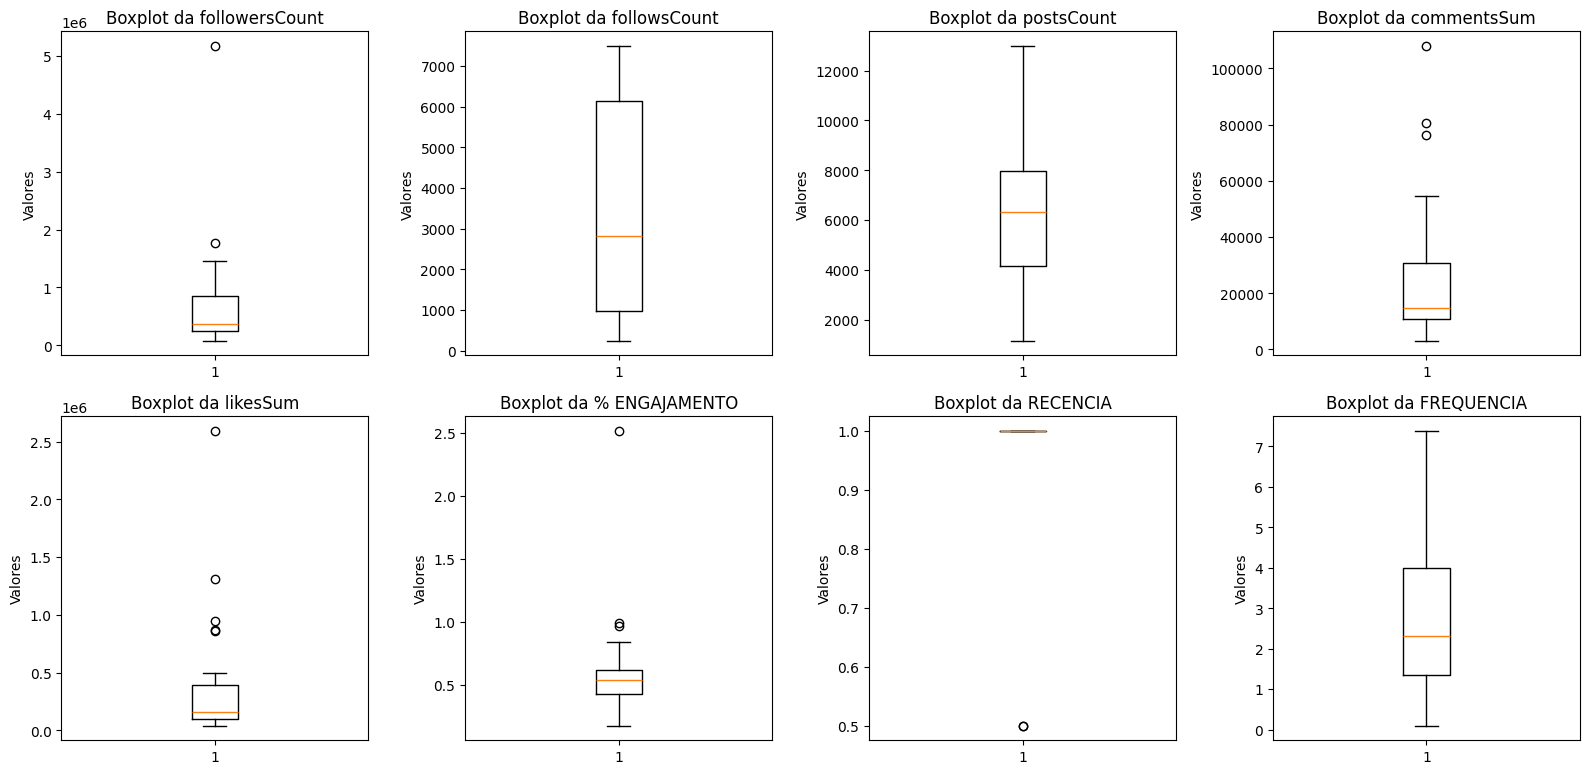

In [15]:
def plotarFigura1():

    df = df_profiles[['followersCount', 'followsCount', 'postsCount', 'commentsSum', 'likesSum', '% ENGAJAMENTO', 'RECENCIA', 'FREQUENCIA']]

    # 2. Criar a figura e os eixos (subplots)
    # A estrutura da grade continua a mesma: 2 linhas e 4 colunas.
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

    # 3. "Achatando" o array de eixos para facilitar a iteração
    axes = axes.flatten()

    # 4. Iterar pelas colunas do DataFrame e plotar cada uma em um eixo
    # Usamos enumerate(df.columns) para obter tanto o índice (i) quanto o nome da coluna.
    for i, col_name in enumerate(df.columns):
        # Selecionamos o eixo atual (axes[i])
        ax = axes[i]
        
        # Criamos o boxplot usando os dados da coluna atual (df[col_name])
        ax.boxplot(df[col_name])
        
        # Usamos o nome da coluna como título do subplot
        ax.set_title(f'Boxplot da {col_name}')
        ax.set_ylabel('Valores')

    # 5. Ajustar o layout para evitar sobreposição
    plt.tight_layout()

    # 6. Salvar e exibir o gráfico
    plt.savefig('boxplot_do_dataframe.png')

    # Mostra a figura gerada
    plt.show()

plotarFigura1()

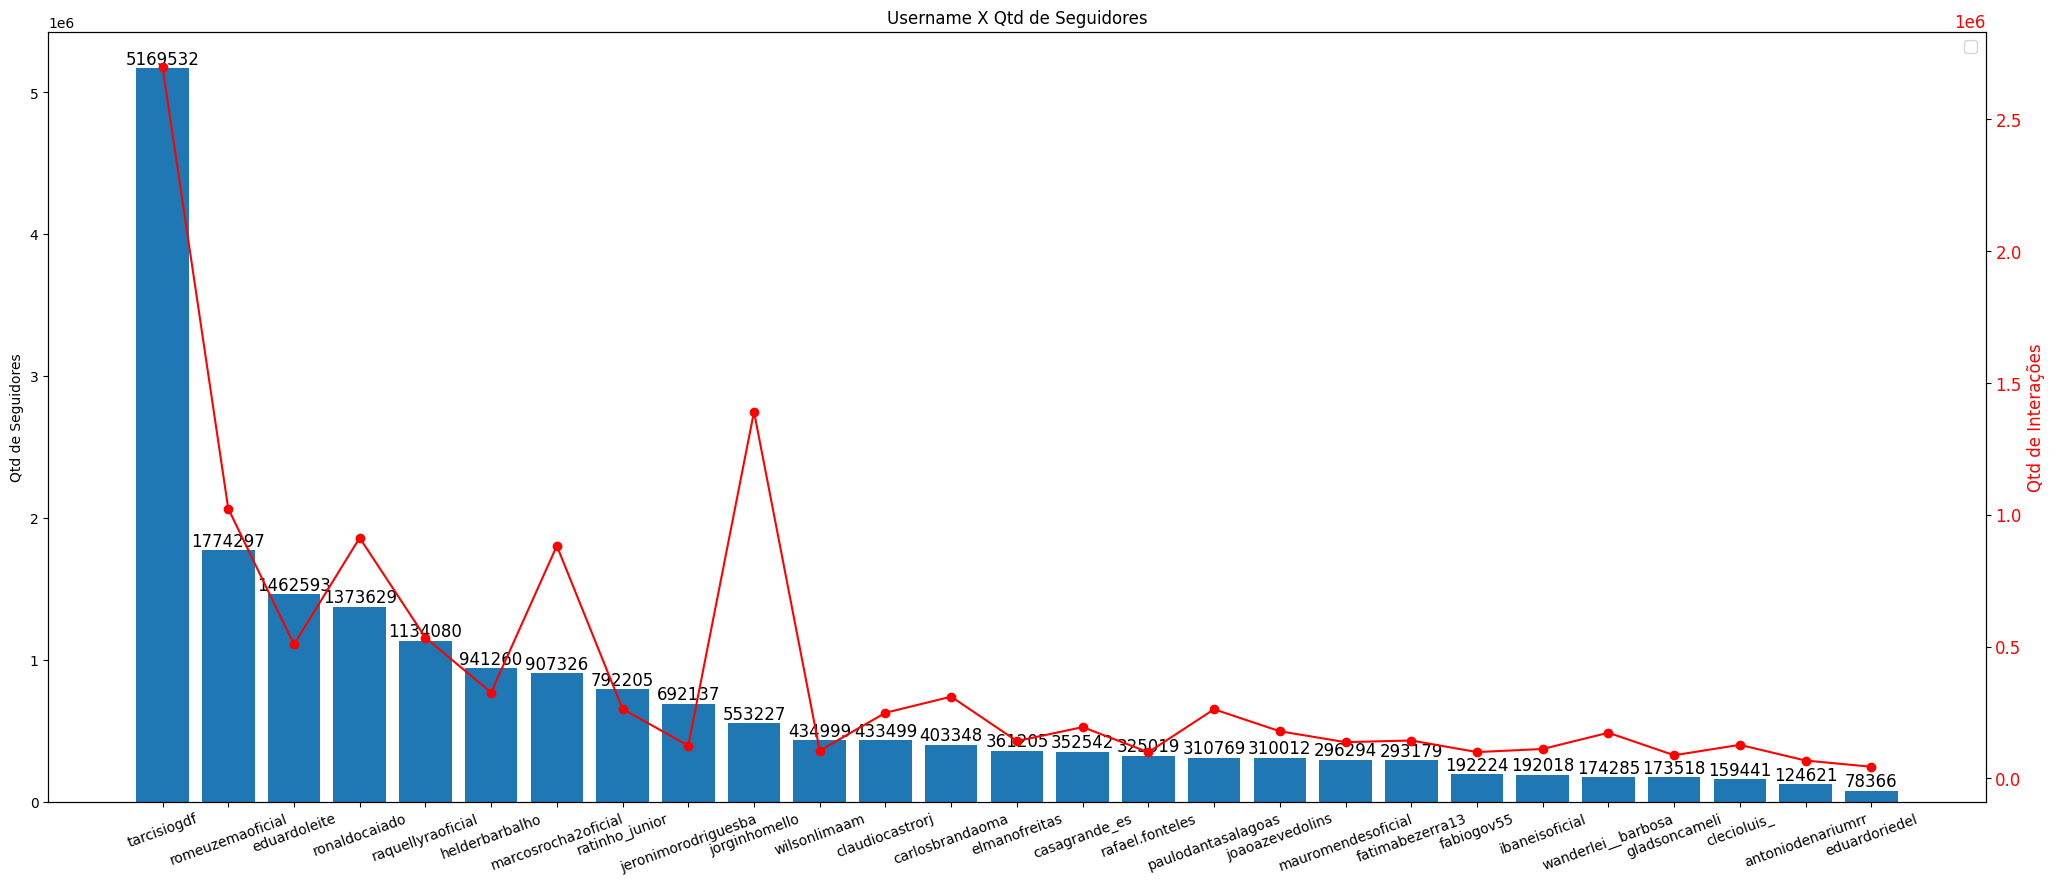

In [16]:
def plotarFigura2():

    # Crie uma figura e um conjunto de subplots (2 linhas, 2 colunas)
    fig, axs = plt.subplots(1, 1, figsize=(25, 10))
    
    # Define os tamanhos de fonte padrão
    plt.rc('font', size=12)          # controla o tamanho da fonte padrão
    plt.rc('axes', titlesize=12)     # tamanho da fonte do título dos eixos
    plt.rc('axes', labelsize=12)     # tamanho da fonte dos rótulos x e y
    plt.rc('xtick', labelsize=12)    # tamanho da fonte dos ticks do eixo x
    plt.rc('ytick', labelsize=12)    # tamanho da fonte dos ticks do eixo y
    plt.rc('legend', fontsize=12)    # tamanho da fonte da legenda
    plt.rc('figure', titlesize=12)   # tamanho da fonte do título da figura
    
    # --- Gráfico para 'Categoria A' ---
    # Conta e ordena os valores em ordem decrescente
    df = df_profiles.sort_values(by='followersCount', ascending=False)

    # Cria o gráfico de barras verticais
    bars = axs.bar(df['username'], df['followersCount'])
    axs.bar_label(bars, fmt='%.0f', label_type='edge')  # valores inteiros

    # Adiciona um título e um rótulo ao eixo y
    axs.set_title('Username X Qtd de Seguidores')
    axs.set_ylabel('Qtd de Seguidores')
    axs.tick_params(axis='x', rotation=20)

    # --- Gráfico de Linhas (Eixo Y Direito) ---
    # Cria um segundo eixo que compartilha o mesmo eixo x
    ax2 = axs.twinx()
    # Plota a segunda métrica (ex: 'followingCount') como uma linha
    df['LikesCommentsSum'] = df['likesSum'] + df['commentsSum']
    ax2.plot(df['username'], df['LikesCommentsSum'], color='red', marker='o', linestyle='-')
    ax2.set_ylabel('Qtd de Interações', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # --- Legenda Combinada ---
    # Para ter uma única legenda, pegamos os "handles" e "labels" de ambos os eixos
    lines, labels = axs.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plotarFigura2()

NameError: name 'ax2' is not defined

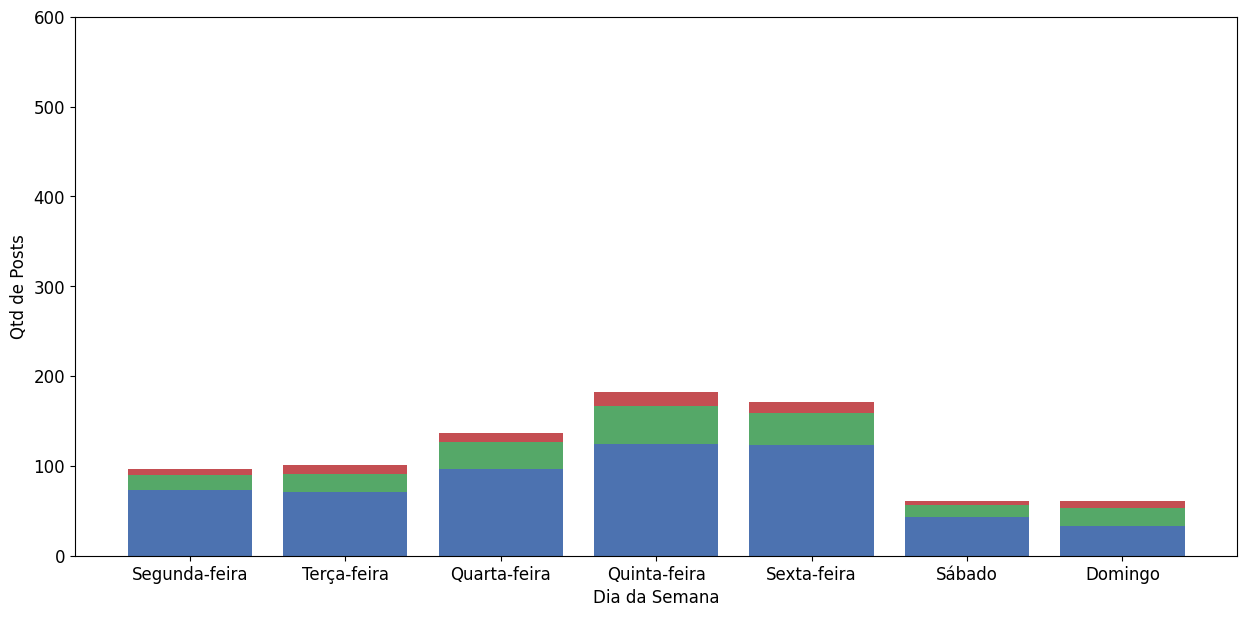

In [17]:
# 2. Crie o dicionário de mapeamento
dias_semana_map = {
    0: 'Segunda-feira',
    1: 'Terça-feira',
    2: 'Quarta-feira',
    3: 'Quinta-feira',
    4: 'Sexta-feira',
    5: 'Sábado',
    6: 'Domingo'
}

df_posts['dia_da_semana'] = df_posts['data_hora'].dt.dayofweek.map(dias_semana_map)

df_proporcao_type = df_posts.groupby(['dia_da_semana', 'type']).size().reset_index().pivot(index='dia_da_semana', columns='type', values=0).reset_index()

# 2. Defina a ordem correta dos dias da semana
ordem_dos_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

# 3. Converta a coluna 'dia_da_semana' para o tipo Categórico com a ordem definida
df_proporcao_type['dia_da_semana'] = pd.Categorical(df_proporcao_type['dia_da_semana'], categories=ordem_dos_dias, ordered=True)

# 4. Ordene o DataFrame pela coluna 'dia_da_semana'
df_ordenado = df_proporcao_type.sort_values(by='dia_da_semana')

# Gráfico
fig, ax1 = plt.subplots(figsize=(15, 7))

# --- Barras Empilhadas ---

# 1. Barra da base
ax1.bar(df_ordenado['dia_da_semana'], df_ordenado['Video'], label='Video', color='#4c72b0')

# 2. Segunda barra, empilhada sobre a primeira
ax1.bar(df_ordenado['dia_da_semana'], df_ordenado['Sidecar'], bottom=df_ordenado['Video'], label='Roupas', color='#55a868')

# 3. Terceira barra, empilhada sobre a soma das duas primeiras
bottom_para_acessorios = df_ordenado['Video'] + df_ordenado['Sidecar']
ax1.bar(df_ordenado['dia_da_semana'], df_ordenado['Image'], bottom=bottom_para_acessorios, label='Acessórios', color='#c44e52')

# Configurações do Eixo Y1 (Barras)
ax1.set_ylabel('Qtd de Posts')
# Aumentar o limite do eixo Y para acomodar as barras empilhadas
ax1.set_ylim(0, 600) 
ax1.set_xlabel('Dia da Semana')

# Legenda combinada e Título
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Qtd de Posts X Dias da Semana')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()